In [62]:
import requests as req
import json
import math
import os

import matplotlib.pyplot as plt
import seaborn as sns

# Get metadata from Dataverse for each DOI

In [2]:
from string import Template
query_base=Template('https://dataverse.harvard.edu/api/search?q="${doi}"&show_facets=true')

In [3]:
import pandas
unique_dois = pandas.read_csv("../get-dois/dataset_dois.txt", names=['DOI'])

In [4]:
unique_dois.head()

,DOI
0,doi:10.7910/DVN/U3QJQZ
1,doi:10.7910/DVN/HRLHA4
2,doi:10.7910/DVN/RJWU7A
3,doi:10.7910/DVN/FAAMAX
4,doi:10.7910/DVN/PAHRCK


In [5]:
unique_dois = unique_dois['DOI'].values.tolist()

In [6]:
len(unique_dois)

2002

In [9]:
query = query_base.substitute(doi = unique_dois[0])
res = req.get(query)
res_dict = json.loads(res.text)

In [12]:
time = str(res_dict['data']['items'][0]['published_at'][:4])
time

'2020'

In [17]:
all_metadata=""
bla = 0
all_metadata = ','.join(["DOI","publicationDate","publisher","subject"]) + os.linesep
for i,doi in enumerate(unique_dois):
        query = query_base.substitute(doi = doi)

        res = req.get(query)
        res_dict = json.loads(res.text)
        try:
            time = res_dict['data']['items'][0]['published_at'][:4]
        except IndexError:
            
            print res_dict['data']['items']
            bla+=1
            
        try:
            subs = res_dict['data']['facets'][0]['subject_ss']['labels']
            subject = ";".join(str(s.keys()[0]) for s in subs)
        except KeyError:
            subs = "NA"
            bla +=1
        
        try:
            publisher = res_dict['data']['items'][0]['identifier_of_dataverse']
        except IndexError:
            print doi
            print res_dict['data']
            
        metadata_line = ','.join([doi.strip(), time, publisher.replace(",",";"), subject.replace(",",";")])
        #print metadata_line
        all_metadata += metadata_line + os.linesep

[]
doi:10.7910/DVN/SQ5WBN
{u'spelling_alternatives': {}, u'total_count': 0, u'facets': [{}], u'q': u'"doi:10.7910/DVN/SQ5WBN"', u'start': 0, u'count_in_response': 0, u'items': []}


In [18]:
import pandas as pd 
from StringIO import StringIO

df = pd.read_csv(StringIO(all_metadata))
#df = pd.read_csv(StringIO(all_metadata), delimiter=',')
df.head()

,DOI,publicationDate,publisher,subject
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences
1,doi:10.7910/DVN/HRLHA4,2016,pan,Mathematical Sciences;Social Sciences
2,doi:10.7910/DVN/RJWU7A,2015,intertransferuschina,Social Sciences
3,doi:10.7910/DVN/FAAMAX,2018,BLS-PNAS,Social Sciences
4,doi:10.7910/DVN/PAHRCK,2019,internationalinteractions,Social Sciences


In [19]:
len(df)

2002

In [20]:
with open('all_metadata.txt','w') as f:
    f.write(all_metadata.encode('utf8'))

# Load AWS Batch results

In [27]:
results = pd.read_csv("run_log_sto1.csv", sep="\t", names=["DOI", "file", "result"])

In [28]:
results.head()

,DOI,file,result
0,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,success
1,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,success
2,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,success
3,doi:10.7910/DVN/BPON3K,fig_13_plot_loyalty_df_pct.R,Error in data.table(x) : object 'x' not found
4,doi:10.7910/DVN/BPON3K,fig_14_effect_on_individual_parties.R,Error in theme_tufte(base_size = 15) : [newlin...


In [29]:
len(results)

5061

In [30]:
import seaborn as sns
sns.set_style("whitegrid")
# plot
barWidth = 0.8

# Merge

In [32]:
total = pd.merge(df,results,on='DOI')

In [42]:
len(total)

5061

In [43]:
total.head()

,DOI,publicationDate,publisher,subject,file,result
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,microcosm_analysis_code_2-12-20.R,"Error in otu_table(as.matrix(expfn), taxa_are_..."
1,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,unknown,time limit exceeded
2,doi:10.7910/DVN/HRLHA4,2016,pan,Mathematical Sciences;Social Sciences,harbersingram20161228_basic.R,Error in source(r_file) : [newline] harbersin...
3,doi:10.7910/DVN/RJWU7A,2015,intertransferuschina,Social Sciences,Table1.R,"Error in readChar(con, 5L, useBytes = TRUE) : ..."
4,doi:10.7910/DVN/RJWU7A,2015,intertransferuschina,Social Sciences,Table2.R,"Error in readChar(con, 5L, useBytes = TRUE) : ..."


In [53]:
def success(el):
    if "success" in el:
        return 1
    if "time limit exceeded" in el:
        return 2
    return 0

total['success']=total["result"].apply(success)

# Re-execution rate per journal

In [54]:
unique = df['publisher'].unique()
unique[:10]

array(['harvard', 'pan', 'intertransferuschina', 'BLS-PNAS',
       'internationalinteractions', 'isq', 'monogan', 'govdept', 'restat',
       'palcomms'], dtype=object)

In [45]:
qbase=Template('https://dataverse.harvard.edu/api/dataverses/${iddv}')

all_journals = ""
for i,iddv in enumerate(unique):
    query = qbase.substitute(iddv = iddv)
    res = req.get(query)
    res_dict = json.loads(res.text)
    
    name = res_dict['data']['name']
    dvtype = res_dict['data']['dataverseType']
        
    metadata_line = '\t'.join([iddv.strip(), dvtype, name])
    #print metadata_line
    all_journals += metadata_line + os.linesep

In [46]:
dj = pd.read_csv(StringIO(all_journals), sep='\t', names=['publisher', 'type', 'name'])

dj.head()

,publisher,type,name
0,harvard,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
1,pan,JOURNALS,Political Analysis Dataverse
2,intertransferuschina,RESEARCH_PROJECTS,Behind Parent-Child Relationship and Intergene...
3,BLS-PNAS,RESEARCH_PROJECTS,Bechtel Liesch Scheve PNAS
4,internationalinteractions,JOURNALS,International Interactions (II): Empirical and...


In [55]:
dmerge = pd.merge(total, dj, on='publisher')

In [56]:
len(dmerge)

5061

In [57]:
dmerge.head()

,DOI,publicationDate,publisher,subject,file,result,success,type,name
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,microcosm_analysis_code_2-12-20.R,"Error in otu_table(as.matrix(expfn), taxa_are_...",0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
1,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,unknown,time limit exceeded,2,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
2,doi:10.7910/DVN/6KEXM7,2020,harvard,Social Sciences,unknown,time limit exceeded,2,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
3,doi:10.7910/DVN/EEUTHP,2019,harvard,Social Sciences,sharia.R,Error in source(r_file) : sharia.R:259:33: une...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
4,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,ModelVillageDistrictProvinceCovariates.R,Error in source(r_file) : [newline] ModelVill...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse


In [211]:
journals = dmerge[dmerge['type']=="JOURNALS"]
journals.head()

,DOI,publicationDate,publisher,subject,file,result,success,type,name
825,doi:10.7910/DVN/HRLHA4,2016,pan,Mathematical Sciences,harbersingram20161228_basic.R,Error in source(r_file) : [newline] harbersin...,0,JOURNALS,Political Analysis Dataverse
826,doi:10.7910/DVN/QXCFO2,2016,pan,Social Sciences,int-out-pscore-plots.R,Error in read.dta(paste(COLOMBIA_STEP9_PSCORE_...,0,JOURNALS,Political Analysis Dataverse
827,doi:10.7910/DVN/QXCFO2,2016,pan,Social Sciences,int-results-balance-tables.R,Error in read.dta(COLOMBIA_STEP9_PSCORE_IMP1.d...,0,JOURNALS,Political Analysis Dataverse
828,doi:10.7910/DVN/QXCFO2,2016,pan,Social Sciences,int-results-graph.R,success,1,JOURNALS,Political Analysis Dataverse
829,doi:10.7910/DVN/QXCFO2,2016,pan,Social Sciences,int-results-performance-metrics.R,"Error in readChar(con, 5L, useBytes = TRUE) : ...",0,JOURNALS,Political Analysis Dataverse


In [212]:
def fix_name(el):
    return el.split('Dataverse')[0].strip()

In [213]:
journals.name = journals.name.apply(lambda x: fix_name(x))
journals.head()

,DOI,publicationDate,publisher,subject,file,result,success,type,name
825,doi:10.7910/DVN/HRLHA4,2016,pan,Mathematical Sciences,harbersingram20161228_basic.R,Error in source(r_file) : [newline] harbersin...,0,JOURNALS,Political Analysis
826,doi:10.7910/DVN/QXCFO2,2016,pan,Social Sciences,int-out-pscore-plots.R,Error in read.dta(paste(COLOMBIA_STEP9_PSCORE_...,0,JOURNALS,Political Analysis
827,doi:10.7910/DVN/QXCFO2,2016,pan,Social Sciences,int-results-balance-tables.R,Error in read.dta(COLOMBIA_STEP9_PSCORE_IMP1.d...,0,JOURNALS,Political Analysis
828,doi:10.7910/DVN/QXCFO2,2016,pan,Social Sciences,int-results-graph.R,success,1,JOURNALS,Political Analysis
829,doi:10.7910/DVN/QXCFO2,2016,pan,Social Sciences,int-results-performance-metrics.R,"Error in readChar(con, 5L, useBytes = TRUE) : ...",0,JOURNALS,Political Analysis


In [214]:
journals.name = journals.name.apply(
    lambda x: 'International Interactions (II)' if 'International Interactions (II)' in x else x)
journals.name = journals.name.apply(
    lambda x: 'American Journal of Political\nScience (AJPS)' if 'American Journal of Political Science (AJPS)' in x else x)
journals.name = journals.name.apply(
    lambda x: 'Political Science Research\nand Methods (PSRM)' if 'Political Science Research and Methods (PSRM)' in x else x)

In [219]:
temp = journals.groupby(
    ['success', 'name']).size().reset_index().pivot(columns='success', index='name', values=0)

temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
temp['total'] = [i+j for i,j in zip(temp[2],temp['total'])]

temp['s'] = [i / j * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [i / j * 100 for i,j in zip(temp[0], temp['total'])]
temp['t'] = [i / j * 100 for i,j in zip(temp[2], temp['total'])]

temp = temp.sort_values(by=['total'], ascending=False).head(11)

In [220]:
temp

success,0,1,2,total,s,f,t
name,,,,,,,
The Journal of Politics,358.0,83.0,64.0,505.0,16.435644,70.891089,12.673267
American Journal of Political\nScience (AJPS),245.0,78.0,70.0,393.0,19.847328,62.340967,17.811705
Political Analysis,241.0,71.0,32.0,344.0,20.639535,70.058140,9.302326
American Political Science Review,180.0,50.0,46.0,276.0,18.115942,65.217391,16.666667
British Journal of Political Science,196.0,40.0,30.0,266.0,15.037594,73.684211,11.278195
Political Science Research\nand Methods (PSRM),158.0,29.0,44.0,231.0,12.554113,68.398268,19.047619
Political Behavior,146.0,53.0,29.0,228.0,23.245614,64.035088,12.719298
International Studies Quarterly,147.0,28.0,13.0,188.0,14.893617,78.191489,6.914894
Review of Economics and Statistics,83.0,21.0,4.0,108.0,19.444444,76.851852,3.703704


In [221]:
names = list(temp.index)
r= range(0,len(temp['s']))

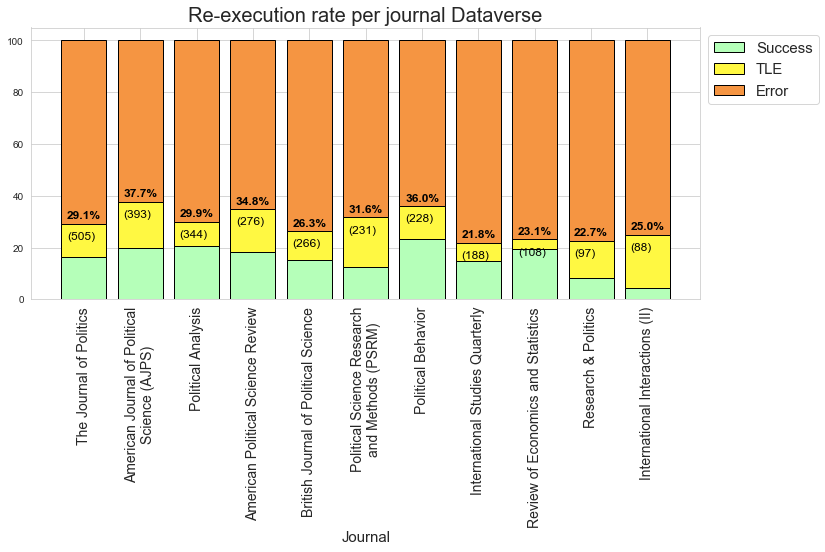

In [222]:
plt.figure(figsize=(12,5))

plt.bar(r, temp['s'], color='#b5ffb9', edgecolor='black', width=barWidth, label="Success")
plt.bar(r, temp['t'], bottom=temp['s'], color='#fFF842', edgecolor='black', width=barWidth, label="TLE")
plt.bar(r, temp['f'], bottom=temp['t']+temp['s'], color='#f59542', edgecolor='black', width=barWidth, label="Error")

plt.xticks(r, names, rotation=90, fontsize=14)
plt.xlabel("Journal", size=15)

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1,prop={'size': 15})

temp['names'] = temp.index
#temp['names'] =temp['names'].apply(fix_name)
temp = temp.reset_index(drop=True)

temp.s = temp.s+temp.t
temp.s = temp.s.round(1)
temp.total = temp.total.astype(int)

for i, rows in temp.iterrows():
    plt.annotate(
        str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
    plt.annotate(
        "("+str(int(rows["total"]))+")", xy=(i-0.3, rows["s"]-6), rotation=0, color="black", size=12)


#plt.annotate("IQSS preliminary", xy=(8, 101), color="grey", size=12)    

plt.title("Re-execution rate per journal Dataverse", size=20)

#plt.tight_layout()
#plt.savefig("publisher.png")
plt.savefig('plots/journals.png', bbox_inches = "tight")
plt.show()

# Re-execution rate per publication year

In [147]:
dmerge.head()

,DOI,publicationDate,publisher,subject,file,result,success,type,name
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,microcosm_analysis_code_2-12-20.R,"Error in otu_table(as.matrix(expfn), taxa_are_...",0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
1,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,unknown,time limit exceeded,2,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
2,doi:10.7910/DVN/6KEXM7,2020,harvard,Social Sciences,unknown,time limit exceeded,2,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
3,doi:10.7910/DVN/EEUTHP,2019,harvard,Social Sciences,sharia.R,Error in source(r_file) : sharia.R:259:33: une...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
4,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,ModelVillageDistrictProvinceCovariates.R,Error in source(r_file) : [newline] ModelVill...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse


In [188]:
temp = dmerge.groupby(
    ['success', 'publicationDate']).size().reset_index().pivot(columns='success', index='publicationDate', values=0)
temp

success,0,1,2
publicationDate,,,
2010,1.0,NaN,NaN
2014,7.0,1.0,NaN
2015,237.0,36.0,22.0
2016,609.0,204.0,61.0
2017,730.0,214.0,88.0
2018,838.0,146.0,176.0
2019,797.0,160.0,274.0
2020,267.0,61.0,132.0


In [189]:
temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
temp['total'] = [i+j for i,j in zip(temp[2],temp['total'])]

temp['s'] = [i / j * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [i / j * 100 for i,j in zip(temp[0], temp['total'])]
temp['t'] = [i / j * 100 for i,j in zip(temp[2], temp['total'])]

#temp = temp.sort_values(by=['year'], ascending=False).head(11)
temp

success,0,1,2,total,s,f,t
publicationDate,,,,,,,
2010,1.0,0.0,0.0,1.0,0.000000,100.000000,0.000000
2014,7.0,1.0,0.0,8.0,12.500000,87.500000,0.000000
2015,237.0,36.0,22.0,295.0,12.203390,80.338983,7.457627
2016,609.0,204.0,61.0,874.0,23.340961,69.679634,6.979405
2017,730.0,214.0,88.0,1032.0,20.736434,70.736434,8.527132
2018,838.0,146.0,176.0,1160.0,12.586207,72.241379,15.172414
2019,797.0,160.0,274.0,1231.0,12.997563,64.744110,22.258327
2020,267.0,61.0,132.0,460.0,13.260870,58.043478,28.695652


In [190]:
names = list(temp.index)
r= range(0,len(temp['s']))

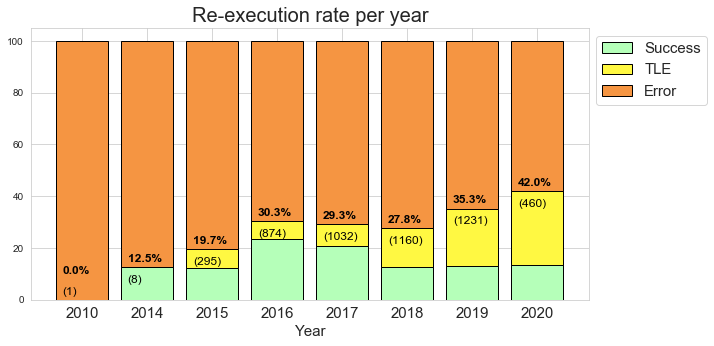

In [191]:
plt.figure(figsize=(10,5))

plt.bar(r, temp['s'], color='#b5ffb9', edgecolor='black', width=barWidth, label="Success")
plt.bar(r, temp['t'], bottom=temp['s'], color='#fFF842', edgecolor='black', width=barWidth, label="TLE")
plt.bar(r, temp['f'], bottom=temp['t']+temp['s'], color='#f59542', edgecolor='black', width=barWidth, label="Error")

plt.xticks(r, names, rotation=0, fontsize=15)
plt.xlabel("Year", size=15)

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1,prop={'size': 15})

temp['year'] = temp.index
#temp['names'] =temp['names'].apply(fix_name)
temp = temp.reset_index(drop=True)

temp.s = temp.s+temp.t
temp.s = temp.s.round(1)
temp.total = temp.total.astype(int)

for i, rows in temp.iterrows():
    if rows["s"]<=0:
        plt.annotate(
            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+10), rotation=0, color="black", size=12, weight='bold')
        plt.annotate(
            "("+str(int(rows["total"]))+")", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12)
    else:
        plt.annotate(
            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
        plt.annotate(
            "("+str(int(rows["total"]))+")", xy=(i-0.3, rows["s"]-6), rotation=0, color="black", size=12)


plt.title("Re-execution rate per year", size=20)

plt.savefig("plots/year.png", bbox_inches = "tight")
plt.show()

# Re-execution rate per subject

In [192]:
dmerge.head()

,DOI,publicationDate,publisher,subject,file,result,success,type,name
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,microcosm_analysis_code_2-12-20.R,"Error in otu_table(as.matrix(expfn), taxa_are_...",0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
1,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,unknown,time limit exceeded,2,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
2,doi:10.7910/DVN/6KEXM7,2020,harvard,Social Sciences,unknown,time limit exceeded,2,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
3,doi:10.7910/DVN/EEUTHP,2019,harvard,Social Sciences,sharia.R,Error in source(r_file) : sharia.R:259:33: une...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
4,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,ModelVillageDistrictProvinceCovariates.R,Error in source(r_file) : [newline] ModelVill...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse


In [194]:
dmerge['subject'] = dmerge.subject.str.replace(';Social Sciences', '')
dmerge.groupby(['subject']).size().nlargest(10)

subject
Social Sciences                                                                              4401
Medicine; Health and Life Sciences                                                             88
Earth and Environmental Sciences                                                               84
Business and Management                                                                        70
Law                                                                                            70
Computer and Information Science                                                               46
Earth and Environmental Sciences;Mathematical Sciences;Medicine; Health and Life Sciences      44
Arts and Humanities                                                                            39
Other                                                                                          30
Mathematical Sciences                                                                          27
dtype: int64

In [195]:
dmerge.subject = dmerge.subject.apply(lambda x: 'Physics' if 'Physics' in x else x)
dmerge.subject = dmerge.subject.apply(lambda x: 'Health and Life Sciences' if 'Health and Life Sciences' in x else x)
dmerge.subject = dmerge.subject.apply(lambda x: 'Earth and Environmental Sciences' if 'Earth and Environmental Sciences' in x else x)
dmerge.subject = dmerge.subject.apply(lambda x: 'Law' if 'Law' in x else x)
dmerge.subject = dmerge.subject.apply(lambda x: 'Computer and Information Science' if 'Computer and Information Science' in x else x)
dmerge.subject = dmerge.subject.apply(lambda x: 'Agricultural Sciences' if 'Agricultural Sciences' in x else x)
dmerge.subject = dmerge.subject.apply(lambda x: 'Business and Management' if 'Business and Management' in x else x)

In [240]:
dmerge.groupby(['subject']).size()

subject
Agricultural Sciences                 26
Arts and Humanities                   39
Business and Management               71
Computer and Information Science      78
Earth and Environmental Sciences     110
Health and Life Sciences             170
Law                                   87
Mathematical Sciences                 27
Other                                 30
Physics                               22
Social Sciences                     4401
dtype: int64

In [241]:
temp = dmerge.groupby(
    ['success', 'subject']).size().reset_index().pivot(columns='success', index='subject', values=0)
temp

success,0,1,2
subject,,,
Agricultural Sciences,22.0,3.0,1.0
Arts and Humanities,28.0,2.0,9.0
Business and Management,51.0,15.0,5.0
Computer and Information Science,54.0,10.0,14.0
Earth and Environmental Sciences,72.0,23.0,15.0
Health and Life Sciences,76.0,72.0,22.0
Law,51.0,23.0,13.0
Mathematical Sciences,21.0,4.0,2.0
Other,12.0,13.0,5.0


In [242]:
temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
temp['total'] = [i+j for i,j in zip(temp[2],temp['total'])]

temp['s'] = [i / j * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [i / j * 100 for i,j in zip(temp[0], temp['total'])]
temp['t'] = [i / j * 100 for i,j in zip(temp[2], temp['total'])]

temp['sortby'] = [i+j for i,j in zip(temp['s'], temp['t'])]

temp = temp.sort_values(by=['sortby'], ascending=False).head(11)
temp

success,0,1,2,total,s,f,t,sortby
subject,,,,,,,,
Other,12.0,13.0,5.0,30.0,43.333333,40.000000,16.666667,60.000000
Health and Life Sciences,76.0,72.0,22.0,170.0,42.352941,44.705882,12.941176,55.294118
Law,51.0,23.0,13.0,87.0,26.436782,58.620690,14.942529,41.379310
Earth and Environmental Sciences,72.0,23.0,15.0,110.0,20.909091,65.454545,13.636364,34.545455
Computer and Information Science,54.0,10.0,14.0,78.0,12.820513,69.230769,17.948718,30.769231
Social Sciences,3077.0,657.0,667.0,4401.0,14.928425,69.915928,15.155646,30.084072
Arts and Humanities,28.0,2.0,9.0,39.0,5.128205,71.794872,23.076923,28.205128
Business and Management,51.0,15.0,5.0,71.0,21.126761,71.830986,7.042254,28.169014
Mathematical Sciences,21.0,4.0,2.0,27.0,14.814815,77.777778,7.407407,22.222222


In [243]:
names = list(temp.index)
r= range(0,len(temp['s']))

In [244]:
names

['Other',
 'Health and Life Sciences',
 'Law',
 'Earth and Environmental Sciences',
 'Computer and Information Science',
 'Social Sciences',
 'Arts and Humanities',
 'Business and Management',
 'Mathematical Sciences',
 'Agricultural Sciences',
 'Physics']

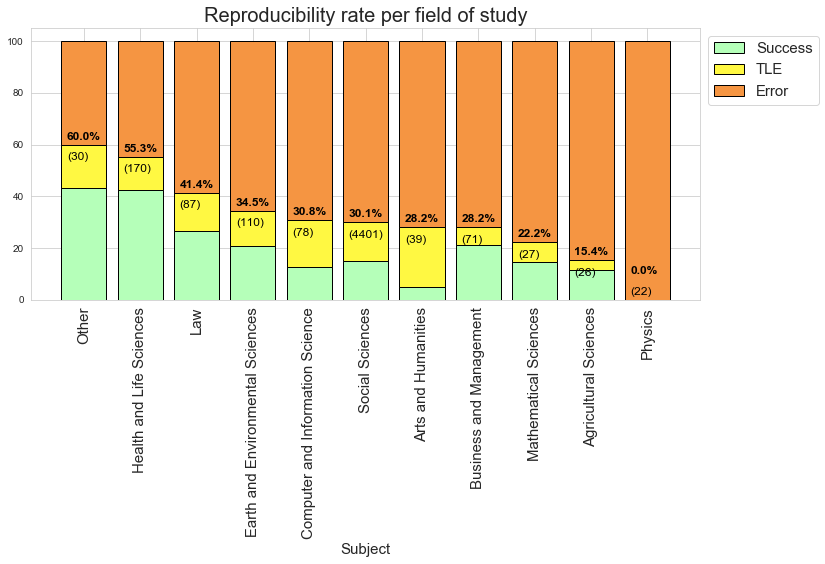

In [245]:
plt.figure(figsize=(12,5))

plt.bar(r, temp['s'], color='#b5ffb9', edgecolor='black', width=barWidth, label="Success")
plt.bar(r, temp['t'], bottom=temp['s'], color='#fFF842', edgecolor='black', width=barWidth, label="TLE")
plt.bar(r, temp['f'], bottom=temp['t']+temp['s'], color='#f59542', edgecolor='black', width=barWidth, label="Error")

plt.xticks(r, names, rotation=90, fontsize=15)
plt.xlabel("Subject", size=15)

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1,prop={'size': 15})

temp['year'] = temp.index
#temp['names'] =temp['names'].apply(fix_name)
temp = temp.reset_index(drop=True)

temp.s = temp.s+temp.t
temp.s = temp.s.round(1)
temp.total = temp.total.astype(int)

for i, rows in temp.iterrows():
    if rows["s"]<=0:
        plt.annotate(
            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+10), rotation=0, color="black", size=12, weight='bold')
        plt.annotate(
            "("+str(int(rows["total"]))+")", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12)
    else:
        plt.annotate(
            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
        plt.annotate(
            "("+str(int(rows["total"]))+")", xy=(i-0.3, rows["s"]-6), rotation=0, color="black", size=12)


plt.title("Reproducibility rate per field of study", size=20)

plt.savefig("plots/subject.png", bbox_inches = "tight")
plt.show()

# Re-execution rate per no of dependencies

In [246]:
dmerge.head()

,DOI,publicationDate,publisher,subject,file,result,success,type,name
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Health and Life Sciences,microcosm_analysis_code_2-12-20.R,"Error in otu_table(as.matrix(expfn), taxa_are_...",0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
1,doi:10.7910/DVN/U3QJQZ,2020,harvard,Health and Life Sciences,unknown,time limit exceeded,2,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
2,doi:10.7910/DVN/6KEXM7,2020,harvard,Social Sciences,unknown,time limit exceeded,2,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
3,doi:10.7910/DVN/EEUTHP,2019,harvard,Social Sciences,sharia.R,Error in source(r_file) : sharia.R:259:33: une...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
4,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,ModelVillageDistrictProvinceCovariates.R,Error in source(r_file) : [newline] ModelVill...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse


In [248]:
df = pd.read_csv("run_log_st11.csv", delimiter='\t', names=["DOI", 'file', 'comm_no', 'dep_no', 'encoding', 'total_lines'])
df.head()

,DOI,file,comm_no,dep_no,encoding,total_lines
0,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,13,4,Windows-1252,188
1,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,8,4,Windows-1252,153
2,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,4,3,Windows-1252,37
3,doi:10.7910/DVN/BPON3K,fig_13_plot_loyalty_df_pct.R,3,5,ascii,27
4,doi:10.7910/DVN/BPON3K,fig_14_effect_on_individual_parties.R,1,0,ascii,1


In [249]:
len(df)

7674

In [250]:
len(dmerge)

5061

In [251]:
nmerge = pd.merge(dmerge, df, on=['DOI','file'])

In [252]:
len(nmerge)

4232

In [272]:
nmerge.head()

,DOI,publicationDate,publisher,subject,file,result,success,type,name,comm_no,dep_no,encoding,total_lines,dep_no_number
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Health and Life Sciences,microcosm_analysis_code_2-12-20.R,"Error in otu_table(as.matrix(expfn), taxa_are_...",0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse,202,1,ascii,1176,1
1,doi:10.7910/DVN/EEUTHP,2019,harvard,Social Sciences,sharia.R,Error in source(r_file) : sharia.R:259:33: une...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse,48,9,ascii,461,9
2,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,ModelVillageDistrictProvinceCovariates.R,Error in source(r_file) : [newline] ModelVill...,0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse,19,0,ascii,151,0
3,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,model-FamilyHarm.R,"Error in jags(data, inits, params, model.file ...",0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse,12,2,ascii,87,2
4,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,model-ManteqaHarm.R,"Error in jags(data, inits, params, model.file ...",0,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse,12,2,ascii,87,2


In [271]:
nmerge['dep_no_number']=pd.to_numeric(nmerge['dep_no'])

In [273]:
temp = nmerge.groupby(
    ['success', 'dep_no_number']).size().reset_index().pivot(columns='success', index='dep_no_number', values=0)
temp

success,0,1
dep_no_number,,
0,1106.0,554.0
1,387.0,110.0
2,420.0,64.0
3,328.0,24.0
4,245.0,20.0
5,215.0,9.0
6,153.0,9.0
7,122.0,7.0
8,67.0,7.0


In [274]:
temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
#temp['total'] = [i+j for i,j in zip(temp[2],temp['total'])]

temp['s'] = [i / j * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [i / j * 100 for i,j in zip(temp[0], temp['total'])]
#temp['t'] = [i / j * 100 for i,j in zip(temp[2], temp['total'])]

#temp = temp.sort_values(by=temp.index, ascending=False).head(11)
temp

success,0,1,total,s,f
dep_no_number,,,,,
0,1106.0,554.0,1660.0,33.373494,66.626506
1,387.0,110.0,497.0,22.132797,77.867203
2,420.0,64.0,484.0,13.223140,86.776860
3,328.0,24.0,352.0,6.818182,93.181818
4,245.0,20.0,265.0,7.547170,92.452830
5,215.0,9.0,224.0,4.017857,95.982143
6,153.0,9.0,162.0,5.555556,94.444444
7,122.0,7.0,129.0,5.426357,94.573643
8,67.0,7.0,74.0,9.459459,90.540541


In [275]:
names = list(temp.index)
r= range(0,len(temp['s']))

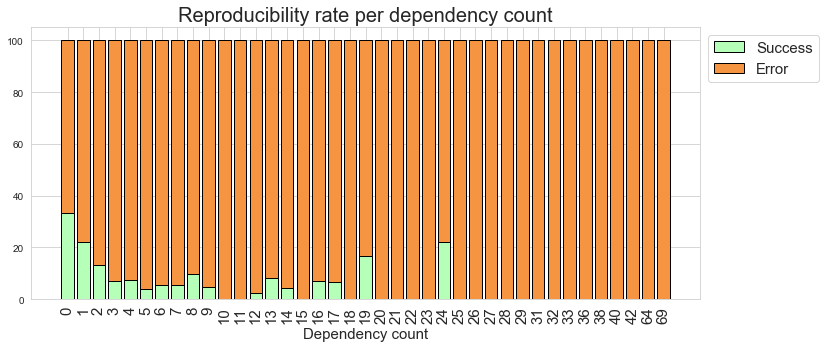

In [278]:
plt.figure(figsize=(12,5))

plt.bar(r, temp['s'], color='#b5ffb9', edgecolor='black', width=barWidth, label="Success")
#plt.bar(r, temp['t'], bottom=temp['s'], color='#fFF842', edgecolor='black', width=barWidth, label="TLE")
plt.bar(r, temp['f'], bottom=temp['s'], color='#f59542', edgecolor='black', width=barWidth, label="Error")

plt.xticks(r, names, rotation=90, fontsize=15)
plt.xlabel("Dependency count", size=15)

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1,prop={'size': 15})

temp['year'] = temp.index
#temp['names'] =temp['names'].apply(fix_name)
temp = temp.reset_index(drop=True)

temp.s = temp.s.round(1)
temp.total = temp.total.astype(int)

#for i, rows in temp.iterrows():
#    if rows["s"]<=0:
#        plt.annotate(
#            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+10), rotation=0, color="black", size=12, weight='bold')
#        plt.annotate(
#            "("+str(int(rows["total"]))+")", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12)
#    else:
#        plt.annotate(
#            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
#        plt.annotate(
#            "("+str(int(rows["total"]))+")", xy=(i-0.3, rows["s"]-6), rotation=0, color="black", size=12)


plt.title("Reproducibility rate per dependency count", size=20)

plt.savefig("plots/exe_dep_no.png", bbox_inches = "tight")
plt.show()

# Re-execution rate per publisher

In [ ]:
total['publisher'] = total.publisher.str.replace('Dataverse', '')
total.publisher = total.publisher.apply(lambda x: 'International Interactions (II)' if 'International Interactions (II)' in x else x)


temp = total.groupby(
    ['success', 'publisher']).size().reset_index().pivot(columns='success', index='publisher', values=0)
temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
temp = temp.sort_values(by=['total'], ascending=False).head(10)
temp['s'] = [i / j * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [i / j * 100 for i,j in zip(temp[0], temp['total'])]

temp=temp.sort_values(by='total', ascending=False)[0:5]

names = list(temp.index)

names = [w.replace("American Journal of Political Science (AJPS)", "American Journal of\nPolitical Science (AJPS)") for w in names]
names = [w.replace("International Studies Quarterly", "International Studies\nQuarterly") for w in names]


r= range(0,len(temp['s']))

plt.figure(figsize=(7,5))

plt.bar(r, temp['s'], color='#b5ffb9', edgecolor='black', width=barWidth, label="Success")
plt.bar(r, temp['f'], bottom=temp['s'], color='#d98cfa', edgecolor='black', width=barWidth, label="Fail")

plt.xticks(r, names, rotation=90, fontsize=14)
plt.xlabel("Publisher", size=15)

#plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1,prop={'size': 15})

plt.legend(loc='upper left', ncol=1, prop={'size': 15})

temp['names'] = temp.index
temp = temp.reset_index(drop=True)

temp.s = temp.s.round(1)
temp.total = temp.total.astype(int)

for i, rows in temp.iterrows():
    plt.annotate(
        str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=15, weight='bold')
    plt.annotate(
        "("+str(rows["total"])+")", xy=(i-0.3, rows["s"]-6), rotation=0, color="black", size=15, weight='bold')


plt.annotate("IQSS preliminary", xy=(3.4, 101.5), color="grey", size=12)    

plt.title("Re-execution rate per publisher", size=20)

#plt.tight_layout()
#plt.savefig("publisher.png")
plt.savefig('publisher.png', bbox_inches = "tight")
plt.show()